## linear operator speed profiling

In [9]:
import numpy as np
from scipy.sparse.linalg import LinearOperator, eigsh
from scipy.stats import beta
import pandas as pd
import seaborn as sns
from graspologic.simulations import sbm
from graspologic.utils import to_laplacian
from time import time
np.set_printoptions(suppress=True)

def make_community(a, b, n=500):
    return beta.rvs(a, b, size=(n, 5))

def gen_covariates(n):
    c1 = make_community(2, 5, n=n)
    c2 = make_community(2, 2, n=n)

    covariates = np.vstack((c1, c2))
    return covariates

def gen_network(n):
    P = np.array([[.08, .02], [.02, .08]])
    A = sbm([n//2, n//2], P)
    Y = gen_covariates(n=n//2)
    return A, Y

nodes = np.geomspace(100, 10000, 20).astype(int)
nodes[nodes % 2 == 1] += 1

true eigenvalues

# Test speed increase in calculating leading eigenvalues

Here is the true speed increase gained from using the Lanczos method, since we do not convert to Laplacian in this code.  
This compares the time it takes to calculate the leading eigenvalue of $YY^\top$ with and without the Lanczos method from the paper.

[Text(0.5, 1.0, 'Speed comparison for calculating leading eigenvalues of Lanczos algorithm compared to calculating $YY^\\top$')]

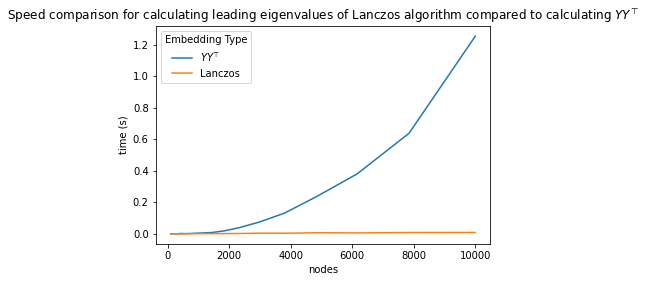

In [11]:
def _matvec(v):
    return Y@(Y.T@v)

slows = {}
fasts = {}
for n in nodes:
    A, Y = gen_network(n)
    
    # calculating Y@Y.T
    start = time()
    YYt = Y@Y.T
    Le_calc = eigsh(YYt, k=1, return_eigenvectors=False)
    slows[n] = time() - start
    
    # as LinearOperator
    start = time()
    YYt_O = LinearOperator((n, n), matvec=_matvec)
    Le_LO = eigsh(YYt_O, k=1, return_eigenvectors=False)
    fasts[n] = time() - start


times = slows.copy()
df = pd.DataFrame(times.values(), index=times.keys(), columns=["Slow"])
df.reset_index(inplace=True)

df["Fast"] = fasts.values()
melted = pd.melt(df, id_vars="index")
melted.rename(columns={"index": "nodes", "variable": "Embedding Type", "value": "time (s)"},
              inplace=True)
melted["Embedding Type"].replace({"Slow": r"$YY^\top$", "Fast": "Lanczos"}, inplace=True)
ax_leading = sns.lineplot(data=melted, x="nodes", y="time (s)", hue="Embedding Type")
ax_leading.set(title=r"Speed comparison for calculating leading eigenvalues of Lanczos algorithm compared to calculating $YY^\top$")

#### Eigenvalues are the same

In [3]:
print(Le_calc)
print(Le_LO)

[8704.63752549]
[8704.63752549]


## Test speed increase in embedding matrix

the source of the exponential growth in the Lanczos version is because converting the adjacency matrix to a Laplacian is not linear, I think

[Text(0.5, 1.0, 'Speed comparison of full embedding for Lanczos algorithm compared to calculating $YY^\\top$')]

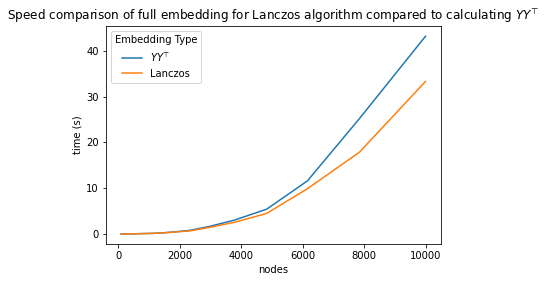

In [4]:
def _matvec(v):
    return L@(L@v) + Y@(Y.T@v)

slows = {}
fasts = {}
for n in nodes:
    A, Y = gen_network(n)
    
    # calculating Y@Y.T
    start = time()
    L = to_laplacian(A, form="R-DAD")
    L_ = L@L + Y@Y.T
    D, U = eigsh(L_, k=2)
    slows[n] = time() - start
    
    # as LinearOperator
    start = time()
    L = to_laplacian(A, form="R-DAD")
    L_ = LinearOperator((n, n), matvec=_matvec)
    D_, U_ = eigsh(L_, k=2)
    fasts[n] = time() - start

times = slows.copy()
df = pd.DataFrame(times.values(), index=times.keys(), columns=["Slow"])
df.reset_index(inplace=True)

df["Fast"] = fasts.values()
melted = pd.melt(df, id_vars="index")
melted.rename(columns={"index": "nodes", "variable": "Embedding Type", "value": "time (s)"},
              inplace=True)
melted.head()
melted["Embedding Type"].replace({"Slow": r"$YY^\top$", "Fast": "Lanczos"}, inplace=True)
ax = sns.lineplot(data=melted, x="nodes", y="time (s)", hue="Embedding Type")
ax.set(title=r"Speed comparison of full embedding for Lanczos algorithm compared to calculating $YY^\top$")

#### Eigenvalues are the same

In [5]:
print(D)
print(D_)

[ 390.1314374  8707.08511132]
[ 390.1314374  8707.08511132]


## graspologic

I went through the CASE code in the debugger to make sure YY^T was never calculated. The source of the exponential growth is converting to Laplacian. Checking symmetry is also an O(n^2) operation, and the graspologic code checks symmetry in both cases.

[Text(0.5, 1.0, 'Speed comparison of CASE with and without Lanczos computation')]

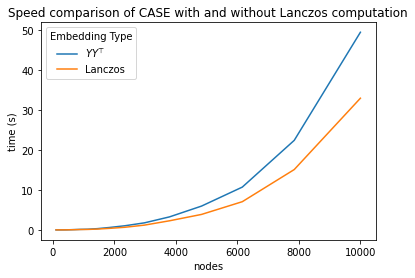

In [6]:
%load_ext autoreload
%autoreload

from graspologic.embed import CovariateAssistedEmbed as CASE
from graspologic.embed.case import CovariateAssistedEmbedOld as CASEOLD

slows = {}
fasts = {}
for n in nodes:
    A, Y = gen_network(n)
    
    # calculating Y@Y.T
    case_old = CASEOLD(n_components=2, embedding_alg="non-assortative")
    start = time()
    case_old.fit_transform((A, Y))
    slows[n] = time() - start
    
    # as LinearOperator
    case = CASE(n_components=2, assortative=False)
    start = time()
    case.fit_transform((A, Y))
    fasts[n] = time() - start
    
times = slows.copy()
df = pd.DataFrame(times.values(), index=times.keys(), columns=["Slow"])
df.reset_index(inplace=True)

df["Fast"] = fasts.values()
melted = pd.melt(df, id_vars="index")
melted.rename(columns={"index": "nodes", "variable": "Embedding Type", "value": "time (s)"},
              inplace=True)
melted["Embedding Type"].replace({"Slow": r"$YY^\top$", "Fast": "Lanczos"}, inplace=True)
ax = sns.lineplot(data=melted, x="nodes", y="time (s)", hue="Embedding Type")
ax.set(title=r"Speed comparison of CASE with and without Lanczos computation")